In [1]:
import numpy as np
import pandas as pd
import pyflux as pf
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tseries.offsets import MonthEnd


## Alameda

### Set up data

In [2]:
master_df = pd.read_csv(r'master_df.csv',encoding='latin-1') 
alameda_df = master_df[master_df.RegionName=='Alameda County'].copy()
alameda_df.drop(['Unnamed: 0','Population', 'Property_Crimes', 'Violent_Crimes','RegionName'], axis=1, inplace=True)
# 'Afford_idx', 'UnemployRate', 'Rate', 'Days_On_Zillow', 'Monthly_List_Zillow'
alameda_df['Date'] = pd.to_datetime(alameda_df.Date)+ MonthEnd(1)

alameda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 7 columns):
Date                   61 non-null datetime64[ns]
Afford_idx             61 non-null float64
SalePrice              61 non-null float64
UnemployRate           61 non-null float64
Rate                   61 non-null float64
Days_On_Zillow         61 non-null float64
Monthly_List_Zillow    61 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 3.8 KB


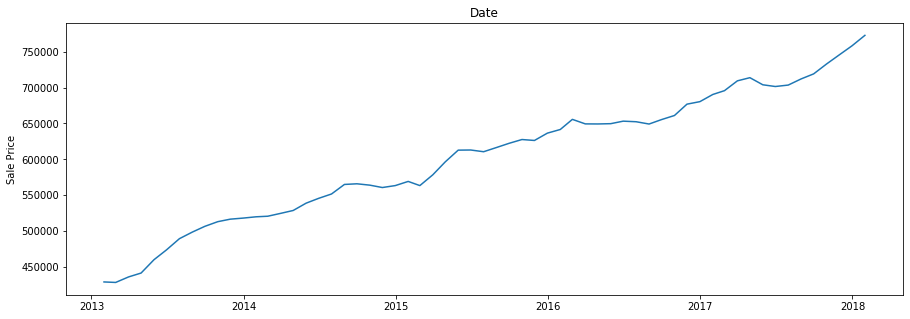

In [3]:

alameda_df.index = alameda_df['Date'];
plt.figure(figsize=(15,5));
plt.plot(alameda_df.index,alameda_df['SalePrice'])
plt.ylabel('Sale Price')
plt.title('Date')
plt.plot();

In [4]:
# https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/ 
# check if sale price is stationary

from statsmodels.tsa.stattools import adfuller
results =adfuller(alameda_df['SalePrice'])
print(results)
# 0th element is test statistics = -0.51. Smaller value means non-stationary. 
# 1st element is p value = 0.88. This is not small therefore cannot reject null hypothesis. This is non-stationary


(-0.5179599707901515, 0.8884638213318221, 6, 54, {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}, 985.2956268142775)


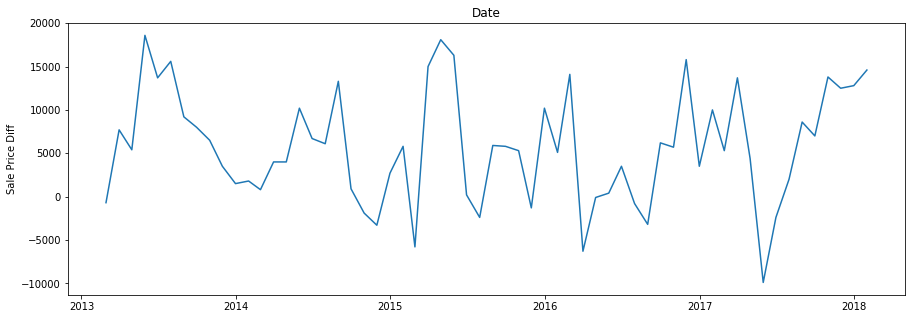

In [5]:
# Make the time series stationary

alameda_diff = alameda_df.diff().dropna() 
plt.figure(figsize=(15,5));
plt.plot(alameda_diff.index,alameda_diff['SalePrice'])
plt.ylabel('Sale Price Diff')
plt.title('Date')
plt.plot();

In [6]:
# Check if stationary
results =adfuller(alameda_diff['SalePrice'])
print(results)

# 0th element is test statistics (ADF Statistic) = -6. Smaller value means non-stationary. 
# 1st element is p value = almost 0. This is small therefore can reject null hypothesis. This is stationary data.
# This means only 1 step of differencing is needed to make the data stationary.


(-6.00889343986812, 1.5909110690202655e-07, 5, 54, {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}, 963.5265867244669)


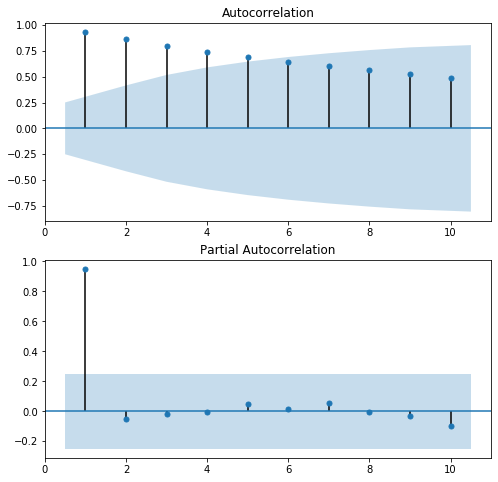

In [7]:
# Find out ACF and PACF to determine AR and/or MA model order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

# Create figure 
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8)) 
# Make ACF plot 
plot_acf(alameda_df['SalePrice'], lags=10, zero=False, ax=ax1) 
# Make PACF plot 
plot_pacf(alameda_df['SalePrice'], lags=10, zero=False, ax=ax2) 
 
plt.show() 

# ACF tails off and PACF cuts off after 1 so we have AR(1) model. 

In [8]:
# Find good model using aic and bic
order_aic_bic =[]
# Loop over AR order 
for p in range(3):    
    # Loop over MA order    
    for q in range(3):         
        # Fit model        
        model = pf.ARIMAX(data=alameda_df, formula='SalePrice~1+UnemployRate+Afford_idx+Days_On_Zillow+Monthly_List_Zillow',
                  ar=p, ma=q, family=pf.Normal())      
        results = model.fit()         
        # print the model order and the AIC/BIC values        
        order_aic_bic.append((p, q, results.aic, results.bic)) 
        
order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'aic', 'bic']) 

# lower aic is better at predicting (lower BIC is better at explaining. In this case, both AIC and BIC are smallest )
print(order_df.sort_values('aic')) 

   p  q          aic          bic
8  2  2  1184.073160  1204.848535
5  1  2  1205.729590  1224.427427
6  2  0  1213.580429  1230.200729
7  2  1  1215.434634  1234.132471
4  1  1  1235.532982  1252.287738
3  1  0  1239.388669  1254.049081
2  0  2  1463.838303  1480.458602
1  0  1  1531.397274  1546.057686
0  0  0  1621.107258  1633.772501


###  Parameters ar=2, ma =2

In [9]:
model = pf.ARIMAX(data=alameda_df, formula='SalePrice~1+UnemployRate+Afford_idx+Days_On_Zillow+Monthly_List_Zillow',
                  ar=2, ma=2, family=pf.Normal())
x = model.fit("MLE")
x.summary()
 

Normal ARIMAX(2,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: SalePrice                           Method: MLE                                       
Start Date: 2013-03-31 00:00:00                         Log Likelihood: -582.0366                         
End Date: 2018-01-31 00:00:00                           AIC: 1184.0732                                    
Number of observations: 59                              BIC: 1204.8485                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.1447     0.1119     1.2938   0.1957   (-0.0745 | 0.3639)       
AR(2)                                

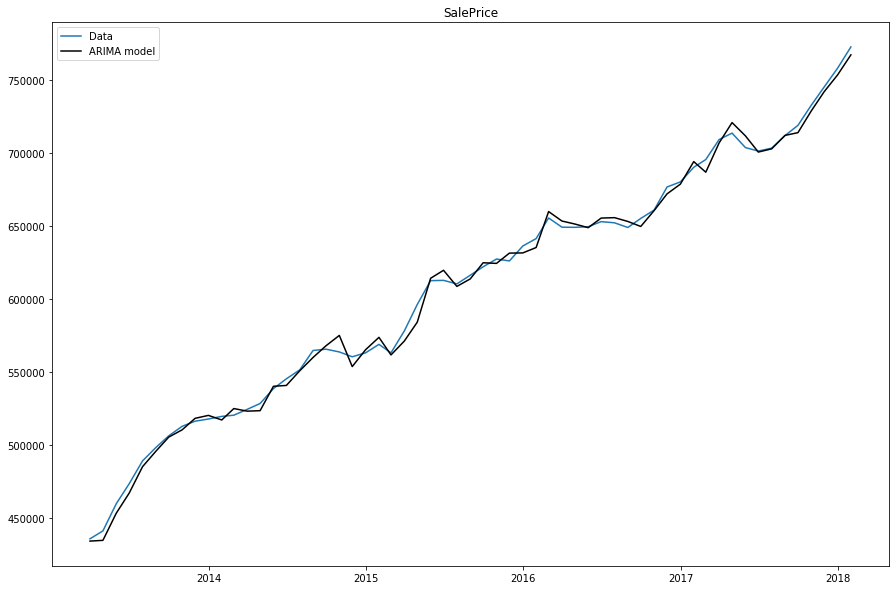

In [10]:
model.plot_fit(figsize=(15,10))

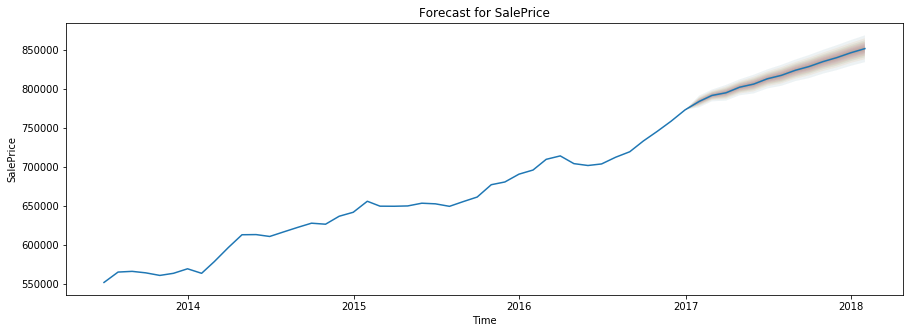

In [11]:
model.plot_predict(h=13, oos_data=alameda_df.iloc[-15:], past_values=43, figsize=(15,5))

In [12]:
forecast_df = model.predict(h=13, oos_data=alameda_df.iloc[-15:], intervals=False)
print(forecast_df)

                SalePrice
Date                     
2017-01-31  783558.467507
2017-02-28  791226.690718
2017-03-31  794631.823694
2017-04-30  801784.817949
2017-05-31  805774.974067
2017-06-30  812553.130032
2017-07-31  816989.209299
2017-08-31  823498.243298
2017-09-30  828278.666172
2017-10-31  834617.253848
2017-11-30  839679.340709
2017-12-31  845912.844506
2018-01-31  851214.460183


### Compare against actual

In [13]:
actual_df = alameda_df[alameda_df.Date>='2017-01-31'] 
actual_df.drop(['Date','Afford_idx' , 'UnemployRate', 'Rate', 'Days_On_Zillow', 'Monthly_List_Zillow'], axis=1, inplace=True)

In [14]:
combine_df = pd.merge(actual_df, forecast_df, on=['Date'], how='inner')

combine_df.columns = ['SalePrice_actual', 'SalePrice_forecast']


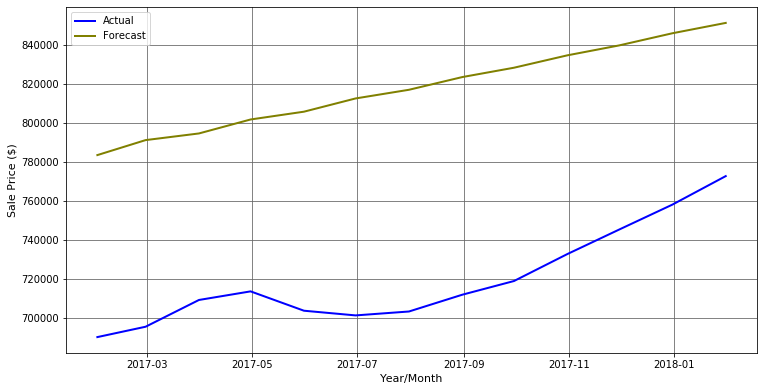

In [15]:
fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])

#axes.plot( 'Date', 'SalePrice_actual', data=combine_df, marker='', color='blue', linewidth=2)
#axes.plot( 'Date', 'SalePrice_forecast', data=combine_df, marker='', color='olive', linewidth=2)  

axes.plot( combine_df.index, combine_df.SalePrice_actual, marker='', color='blue', linewidth=2)
axes.plot( combine_df.index, combine_df.SalePrice_forecast, marker='', color='olive', linewidth=2)  

axes.legend(['Actual', 'Forecast'])

plt.xlabel('Year/Month', fontsize=11)
plt.ylabel('Sale Price ($)', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

## Sacramento

In [16]:
sac_df = master_df[master_df.RegionName=='Sacramento County'].copy()
sac_df.drop(['Unnamed: 0','Population', 'Property_Crimes', 'Violent_Crimes','RegionName'], axis=1, inplace=True)
# 'Afford_idx', 'UnemployRate', 'Rate', 'Days_On_Zillow', 'Monthly_List_Zillow'
sac_df['Date'] = pd.to_datetime(sac_df.Date)+ MonthEnd(1)

sac_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 61 to 121
Data columns (total 7 columns):
Date                   61 non-null datetime64[ns]
Afford_idx             61 non-null float64
SalePrice              61 non-null float64
UnemployRate           61 non-null float64
Rate                   61 non-null float64
Days_On_Zillow         61 non-null float64
Monthly_List_Zillow    61 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 3.8 KB


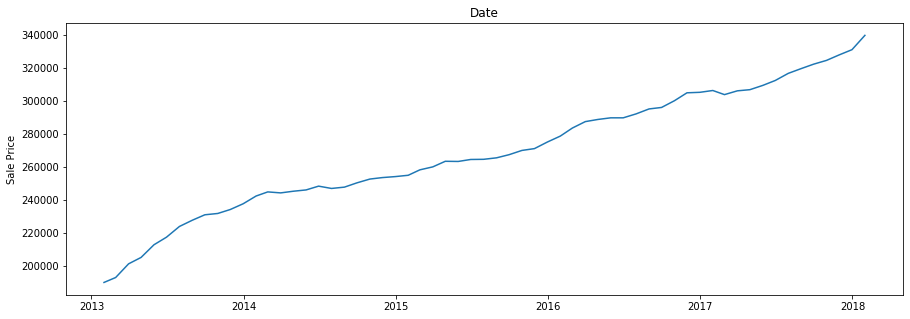

In [17]:
sac_df.index = sac_df['Date'];
plt.figure(figsize=(15,5));
plt.plot(sac_df.index,sac_df['SalePrice'])
plt.ylabel('Sale Price')
plt.title('Date')
plt.plot();

In [18]:
# https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/ 
# check if sale price is stationary

from statsmodels.tsa.stattools import adfuller
results =adfuller(sac_df['SalePrice'])
print(results)
# 0th element is test statistics = 0.26. Smaller value means non-stationary. 
# 1st element is p value = 0.97. This is not small therefore cannot reject null hypothesis. This is non-stationary

(0.262928549928101, 0.975578259550748, 3, 57, {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}, 874.544549593681)


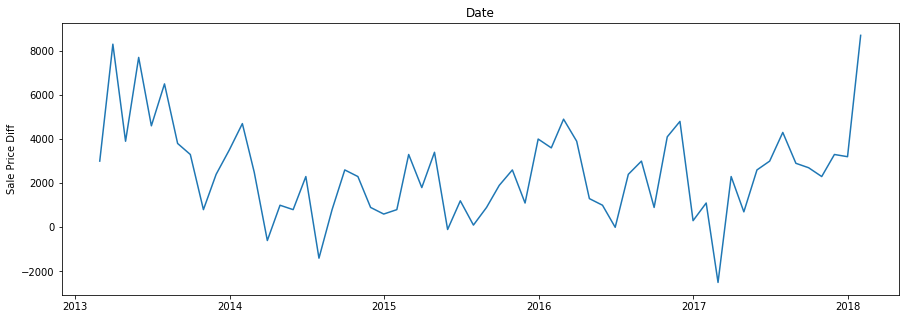

In [19]:
# Make the time series stationary

sac_diff = sac_df.diff().dropna() 
plt.figure(figsize=(15,5));
plt.plot(sac_diff.index, sac_diff['SalePrice'])
plt.ylabel('Sale Price Diff')
plt.title('Date')
plt.plot();

In [20]:
# Check if stationary
results =adfuller(sac_diff['SalePrice'])
print(results)
# 1st element is p value is close to 0. This is small therefore can reject null hypothesis. This is stationary

(-4.420789556988304, 0.000272670587092596, 0, 59, {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}, 858.4782075092091)


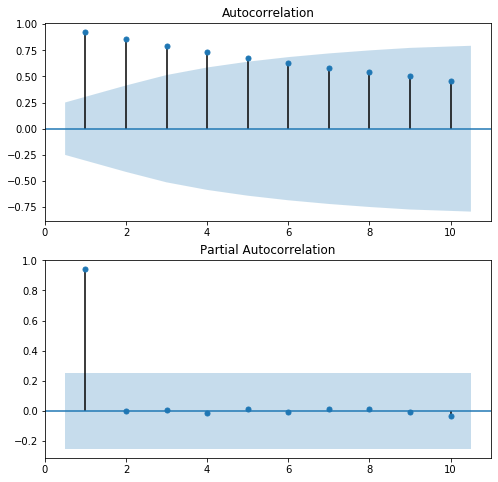

In [21]:
# Find out ACF and PACF to determine AR and/or MA model order

# Create figure 
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8)) 
# Make ACF plot 
plot_acf(sac_df['SalePrice'], lags=10, zero=False, ax=ax1) 
# Make PACF plot 
plot_pacf(sac_df['SalePrice'], lags=10, zero=False, ax=ax2) 
 
plt.show() 

# ACF tails off and PACF cuts off after 1 so we have AR model. 

In [22]:
# Find good model using aic and bic
order_aic_bic =[]
# Loop over AR order 
for p in range(3):    
    # Loop over MA order    
    for q in range(3):         
        # Fit model        
        model = pf.ARIMAX(data=sac_df, formula='SalePrice~1+UnemployRate+Afford_idx+Days_On_Zillow+Monthly_List_Zillow',
                  ar=p, ma=q, family=pf.Normal())      
        results = model.fit()         
        # print the model order and the AIC/BIC values        
        order_aic_bic.append((p, q, results.aic, results.bic)) 
        
order_sac_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'aic', 'bic']) 

# lower aic is better at predicting (lower BIC is better at explaining. In this case, both AIC and BIC are smallest )
print(order_sac_df.sort_values('aic')) 

   p  q          aic          bic
7  2  1  1067.054250  1085.752087
5  1  2  1069.906896  1088.604733
8  2  2  1079.288316  1100.063690
6  2  0  1079.560114  1096.180414
4  1  1  1102.392483  1119.147239
3  1  0  1107.230753  1121.891165
2  0  2  1335.754317  1352.374616
1  0  1  1395.910888  1410.571300
0  0  0  1485.157808  1497.823051


###  Parameters ar=2, ma =1

In [23]:
model_s = pf.ARIMAX(data=sac_df, formula='SalePrice~1+UnemployRate+Afford_idx+Days_On_Zillow+Monthly_List_Zillow',
                  ar=2, ma=1, family=pf.Normal())
x_s = model_s.fit("MLE")
x_s.summary()

Normal ARIMAX(2,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: SalePrice                           Method: MLE                                       
Start Date: 2013-03-31 00:00:00                         Log Likelihood: -524.5271                         
End Date: 2018-01-31 00:00:00                           AIC: 1067.0543                                    
Number of observations: 59                              BIC: 1085.7521                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    1.7799     0.0472     37.7217  0.0      (1.6874 | 1.8724)        
AR(2)                                

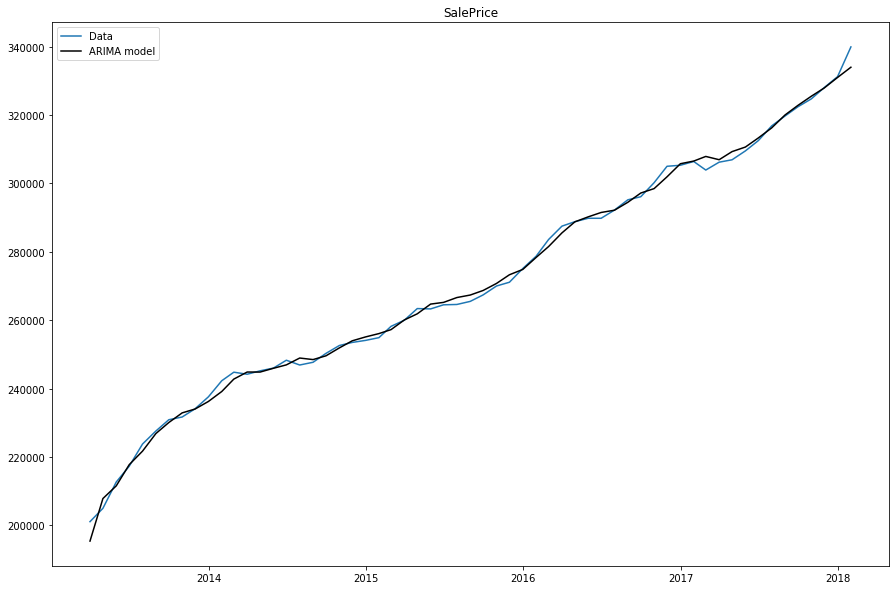

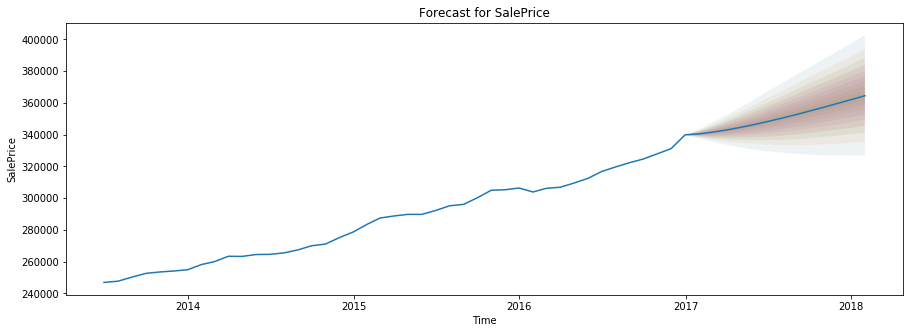

In [24]:
model_s.plot_fit(figsize=(15,10))

model_s.plot_predict(h=13, oos_data=sac_df.iloc[-15:], past_values=43, figsize=(15,5))

forecast_df_s = model_s.predict(h=13, oos_data=sac_df.iloc[-15:], intervals=False)

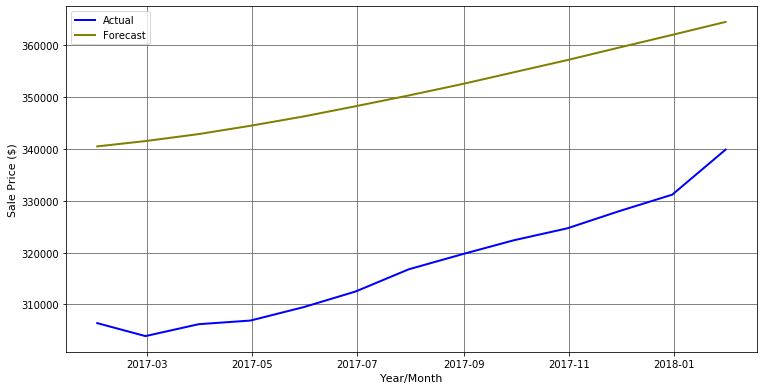

In [25]:
### Compare against actual

actual_sac_df = sac_df[sac_df.Date>='2017-01-31'] 
actual_sac_df.drop(['Date','Afford_idx' , 'UnemployRate', 'Rate', 'Days_On_Zillow', 'Monthly_List_Zillow'], axis=1, inplace=True)



combine_df_s = pd.merge(actual_sac_df, forecast_df_s, on=['Date'], how='inner')

combine_df_s.columns = ['SalePrice_actual', 'SalePrice_forecast']


fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])

#axes.plot( 'Date', 'SalePrice_actual', data=combine_df, marker='', color='blue', linewidth=2)
#axes.plot( 'Date', 'SalePrice_forecast', data=combine_df, marker='', color='olive', linewidth=2)  

axes.plot( combine_df_s.index, combine_df_s.SalePrice_actual, marker='', color='blue', linewidth=2)
axes.plot( combine_df_s.index, combine_df_s.SalePrice_forecast, marker='', color='olive', linewidth=2)  

axes.legend(['Actual', 'Forecast'])

plt.xlabel('Year/Month', fontsize=11)
plt.ylabel('Sale Price ($)', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

## L.A

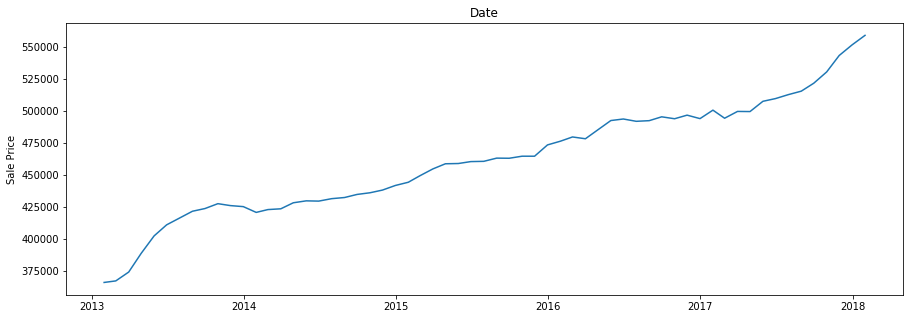

In [26]:
la_df = master_df[master_df.RegionName=='Los Angeles County'].copy()
la_df.drop(['Unnamed: 0','Population', 'Property_Crimes', 'Violent_Crimes','RegionName'], axis=1, inplace=True)
# 'Afford_idx', 'UnemployRate', 'Rate', 'Days_On_Zillow', 'Monthly_List_Zillow'
la_df['Date'] = pd.to_datetime(la_df.Date)+ MonthEnd(1)

la_df.index = la_df['Date'];
plt.figure(figsize=(15,5));
plt.plot(la_df.index,la_df['SalePrice'])
plt.ylabel('Sale Price')
plt.title('Date')
plt.plot();

In [27]:
# https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/ 
# check if sale price is stationary

results =adfuller(la_df['SalePrice'])
print(results)
# 0th element is test statistics = 1.68. Smaller value means non-stationary. 
# 1st element is p value = 0.99. This is not small therefore cannot reject null hypothesis. This is non-stationary


(1.687867148748117, 0.9980986381545782, 6, 54, {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}, 928.3991113254638)


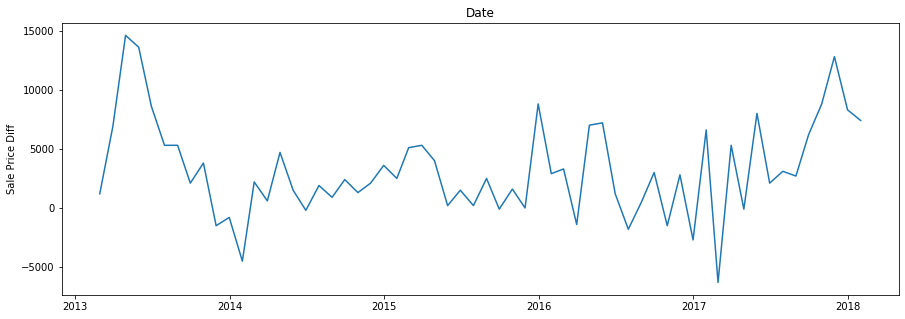

In [28]:
la_diff = la_df.diff().dropna() 
plt.figure(figsize=(15,5));
plt.plot(la_diff.index,la_diff['SalePrice'])
plt.ylabel('Sale Price Diff')
plt.title('Date')
plt.plot();

In [29]:
# Check if stationary
results =adfuller(la_diff['SalePrice'])
print(results)

# 1st element is p value is close to 0. This is small therefore can reject null hypothesis. This is stationary

(-3.5021909437550622, 0.007931003947250494, 5, 54, {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}, 909.1482048529584)


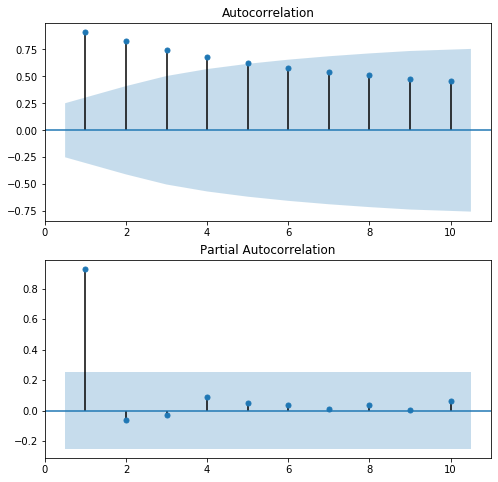

In [30]:
# Find out ACF and PACF to determine AR and/or MA model order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

# Create figure 
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8)) 
# Make ACF plot 
plot_acf(la_df['SalePrice'], lags=10, zero=False, ax=ax1) 
# Make PACF plot 
plot_pacf(la_df['SalePrice'], lags=10, zero=False, ax=ax2) 
 
plt.show() 

# ACF tails off and PACF cuts off after 1 so we have AR model. 

In [31]:
# Find good model using aic and bic
order_aic_bic =[]
# Loop over AR order 
for p in range(3):    
    # Loop over MA order    
    for q in range(3):         
        # Fit model        
        model = pf.ARIMAX(data=la_df, formula='SalePrice~1+UnemployRate+Afford_idx+Days_On_Zillow+Monthly_List_Zillow',
                  ar=p, ma=q, family=pf.Normal())      
        results = model.fit()         
        # print the model order and the AIC/BIC values        
        order_aic_bic.append((p, q, results.aic, results.bic)) 
        
order_la_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'aic', 'bic']) 

# lower aic is better at predicting (lower BIC is better at explaining. In this case, both AIC and BIC are smallest )
print(order_la_df.sort_values('aic')) 

   p  q          aic          bic
8  2  2  1143.923635  1164.699009
5  1  2  1146.097090  1164.794927
7  2  1  1149.889303  1168.587140
6  2  0  1155.623985  1172.244284
4  1  1  1177.755076  1194.509833
3  1  0  1180.255113  1194.915525
2  0  2  1438.471398  1455.091698
1  0  1  1471.179387  1485.839799
0  0  0  1558.774020  1571.439263


In [32]:
model_l = pf.ARIMAX(data=la_df, formula='SalePrice~1+UnemployRate+Afford_idx+Days_On_Zillow+Monthly_List_Zillow',
                  ar=2, ma=2, family=pf.Normal())
x_l = model_l.fit("MLE")
x_l.summary()

Normal ARIMAX(2,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: SalePrice                           Method: MLE                                       
Start Date: 2013-03-31 00:00:00                         Log Likelihood: -561.9618                         
End Date: 2018-01-31 00:00:00                           AIC: 1143.9236                                    
Number of observations: 59                              BIC: 1164.699                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.4991     0.2281     2.1886   0.0286   (0.0521 | 0.9461)        
AR(2)                                

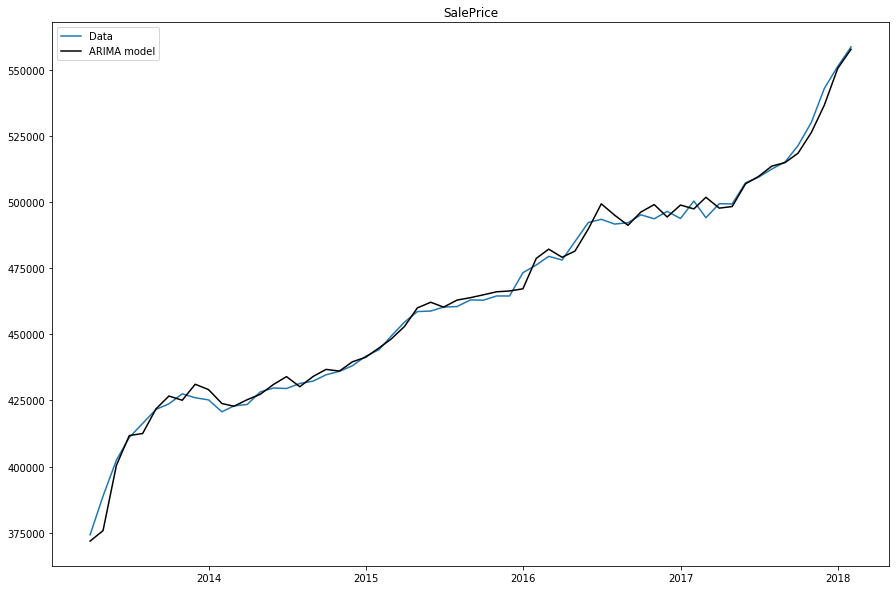

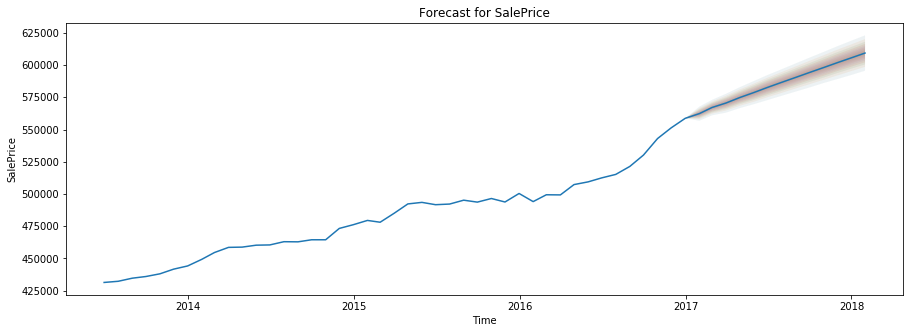

In [35]:
model_l.plot_fit(figsize=(15,10))

model_l.plot_predict(h=13, oos_data=la_df.iloc[-15:], past_values=43, figsize=(15,5))

forecast_df_l = model_l.predict(h=13, oos_data=la_df.iloc[-15:], intervals=False)

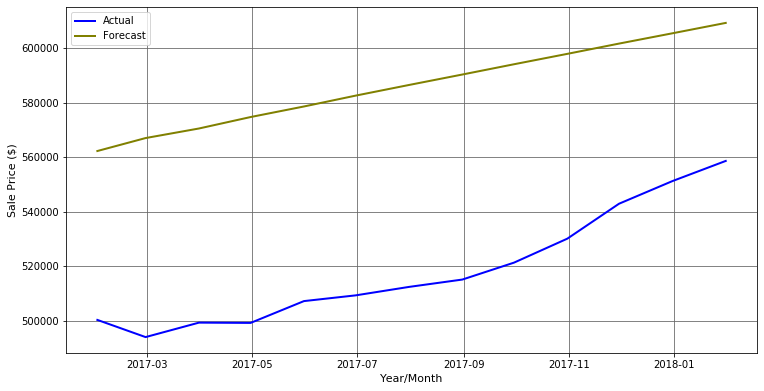

In [34]:
### Compare against actual

actual_la_df = la_df[la_df.Date>='2017-01-31'] 
actual_la_df.drop(['Date','Afford_idx' , 'UnemployRate', 'Rate', 'Days_On_Zillow', 'Monthly_List_Zillow'], axis=1, inplace=True)



combine_df_l = pd.merge(actual_la_df, forecast_df_l, on=['Date'], how='inner')

combine_df_l.columns = ['SalePrice_actual', 'SalePrice_forecast']


fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])

#axes.plot( 'Date', 'SalePrice_actual', data=combine_df, marker='', color='blue', linewidth=2)
#axes.plot( 'Date', 'SalePrice_forecast', data=combine_df, marker='', color='olive', linewidth=2)  

axes.plot( combine_df_l.index, combine_df_l.SalePrice_actual, marker='', color='blue', linewidth=2)
axes.plot( combine_df_l.index, combine_df_l.SalePrice_forecast, marker='', color='olive', linewidth=2)  

axes.legend(['Actual', 'Forecast'])

plt.xlabel('Year/Month', fontsize=11)
plt.ylabel('Sale Price ($)', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()